# Terra Climate Sample Notebook                 

This notebooks demonstrates how to access the TerraClimate dataset and how to create a local GeoTIFF file. TerraClimate is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958 to the present. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. This dataset is provided in Zarr format. 

For more information, visit: https://planetarycomputer.microsoft.com/dataset/terraclimate#overview

## Load Python Dependencies

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import jet
import pandas as pd

# Import Planetary Computer tools
import pystac_client
import planetary_computer



from tqdm import tqdm

## Loading TerraClimate Data

In [2]:
# Access STAC catalog and collection.
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace)

collection = catalog.get_collection("terraclimate")
asset = collection.assets["zarr-abfs"]

In [3]:
# Open dataset and remove CRS.
ds = xr.open_dataset(asset.href,**asset.extra_fields["xarray:open_kwargs"])
ds = ds.drop('crs', dim=None) # Remove the CRS coordinate in the dataset
ds

<xarray.Dataset> Size: 2TB
Dimensions:  (time: 768, lat: 4320, lon: 8640)
Coordinates:
  * lat      (lat) float64 35kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float64 69kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 6kB 1958-01-01 1958-02-01 ... 2021-12-01
Data variables: (12/14)
    aet      (time, lat, lon) float32 115GB dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    def      (time, lat, lon) float32 115GB dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    pdsi     (time, lat, lon) float32 115GB dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    pet      (time, lat, lon) float32 115GB dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ppt      (time, lat, lon) float64 229GB dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    q        (time, lat, lon) float64 229GB dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ...       ...
    swe      (time, lat, lon) float64 229GB dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    tmax     (time, lat, lon) float32 115GB dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    tmin     (time, lat, lon) float32 115GB dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    vap      (time, lat, lon) float32 115GB dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    vpd      (time, lat, lon) float32 115GB dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
    ws       (time, lat, lon) float32 115GB dask.array<chunksize=(12, 1024, 1024), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                     CF-1.6
    acknowledgment:                  Please cite the references included here...
    cdm_data_type:                   GRID
    contributor_email:               khegewisch@ucmerced.edu
    contributor_name:                Katherine Hegewisch
    contributor_role:                Postdoctoral Fellow
    ...                              ...
    time_coverage_duration:          P1Y
    time_coverage_end:               1958-12-01T00:0
    time_coverage_resolution:        P1M
    time_coverage_start:             1958-01-01T00:0
    title:                           TerraClimate: monthly climate and climat...
    version:                         v1.0

A list of the available parameters is shown below:
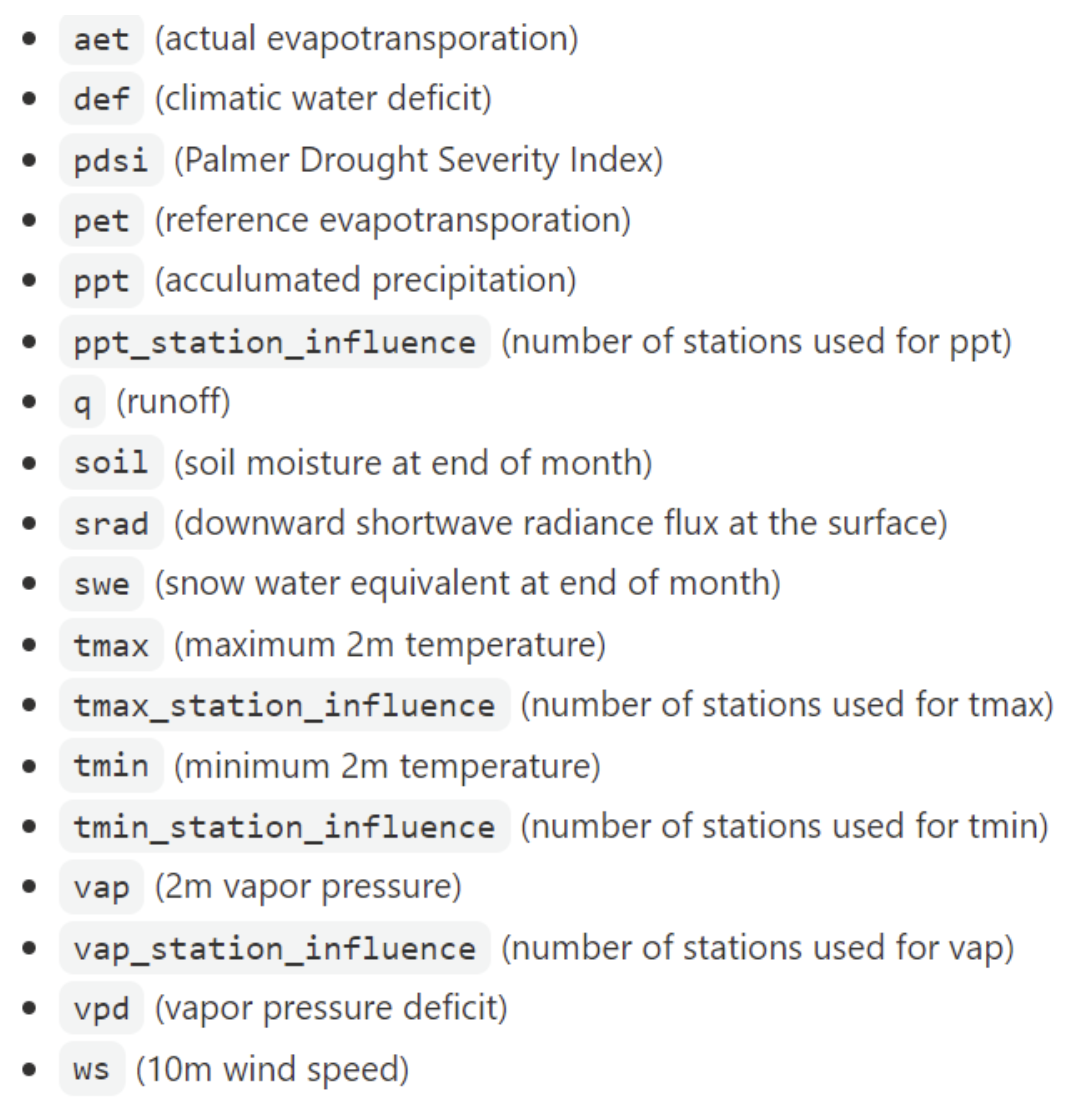

In [4]:
# Get the total memory usage in bytes
total_bytes = ds.nbytes

# Print the memory usage in a common format
print(f"Total memory usage: {total_bytes / 1024**2 / 1024:.0f} GB") 

Total memory usage: 1815 GB


In [5]:
# Since this is a HUGE dataset (nearly 2 TB), we should parse the dataset
# Trimming dataset to years 2017 thru 2019
ds = ds.sel(time=slice("2017-11-01", "2019-11-01"))

In [6]:
# Trimming dataset to the desired Lat-Lon bounds (southeastern Australia)

min_lon = 139.94
min_lat = -39.74
max_lon = 151.48
max_lat = -30.92

mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)

In [7]:
# Crop the dataset to smaller Lat-Lon regions
ds = ds.where(mask_lon & mask_lat, drop=True)
ds

<xarray.Dataset> Size: 100MB
Dimensions:  (time: 25, lat: 212, lon: 277)
Coordinates:
  * lat      (lat) float64 2kB -30.94 -30.98 -31.02 ... -39.65 -39.69 -39.73
  * lon      (lon) float64 2kB 140.0 140.0 140.1 140.1 ... 151.4 151.4 151.5
  * time     (time) datetime64[ns] 200B 2017-11-01 2017-12-01 ... 2019-11-01
Data variables: (12/14)
    aet      (time, lat, lon) float32 6MB dask.array<chunksize=(2, 170, 277), meta=np.ndarray>
    def      (time, lat, lon) float32 6MB dask.array<chunksize=(2, 170, 277), meta=np.ndarray>
    pdsi     (time, lat, lon) float32 6MB dask.array<chunksize=(2, 170, 277), meta=np.ndarray>
    pet      (time, lat, lon) float32 6MB dask.array<chunksize=(2, 170, 277), meta=np.ndarray>
    ppt      (time, lat, lon) float64 12MB dask.array<chunksize=(2, 170, 277), meta=np.ndarray>
    q        (time, lat, lon) float64 12MB dask.array<chunksize=(2, 170, 277), meta=np.ndarray>
    ...       ...
    swe      (time, lat, lon) float64 12MB dask.array<chunksize=(2, 170, 277), meta=np.ndarray>
    tmax     (time, lat, lon) float32 6MB dask.array<chunksize=(2, 170, 277), meta=np.ndarray>
    tmin     (time, lat, lon) float32 6MB dask.array<chunksize=(2, 170, 277), meta=np.ndarray>
    vap      (time, lat, lon) float32 6MB dask.array<chunksize=(2, 170, 277), meta=np.ndarray>
    vpd      (time, lat, lon) float32 6MB dask.array<chunksize=(2, 170, 277), meta=np.ndarray>
    ws       (time, lat, lon) float32 6MB dask.array<chunksize=(2, 170, 277), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                     CF-1.6
    acknowledgment:                  Please cite the references included here...
    cdm_data_type:                   GRID
    contributor_email:               khegewisch@ucmerced.edu
    contributor_name:                Katherine Hegewisch
    contributor_role:                Postdoctoral Fellow
    ...                              ...
    time_coverage_duration:          P1Y
    time_coverage_end:               1958-12-01T00:0
    time_coverage_resolution:        P1M
    time_coverage_start:             1958-01-01T00:0
    title:                           TerraClimate: monthly climate and climat...
    version:                         v1.0

In [8]:
# Get the total memory usage in bytes
total_bytes2 = ds.nbytes

# Print the memory usage in a common format ... notice it is MUCH smaller now!
print(f"Total memory usage: {total_bytes2 / 1024**2:.0f} MB") 

Total memory usage: 95 MB


## Exploring the Data

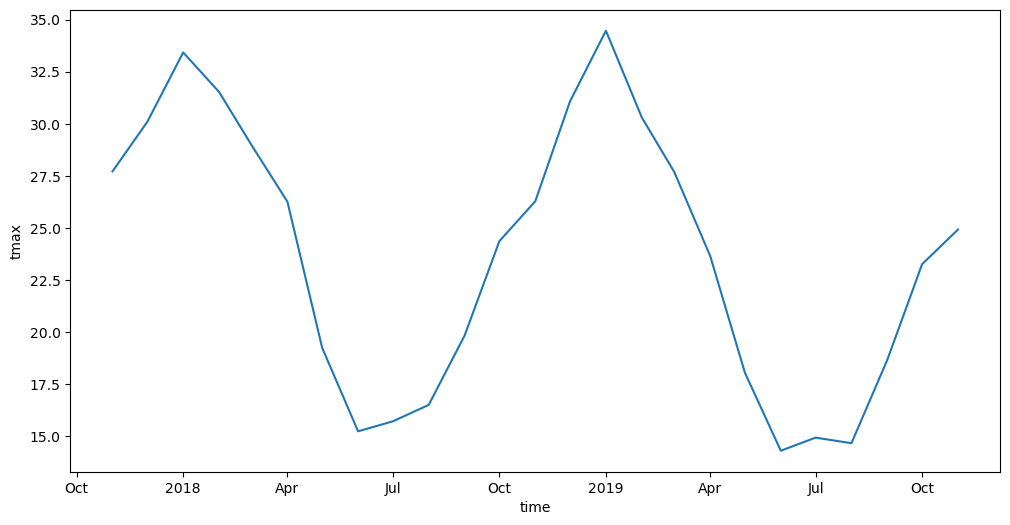

In [9]:
# Plot mean temperature over the region for 2 years
# This will demonstrate the expected seasonal variation
temperature = ds["tmax"].mean(dim=["lat", "lon"])
temperature.plot(figsize=(12, 6));

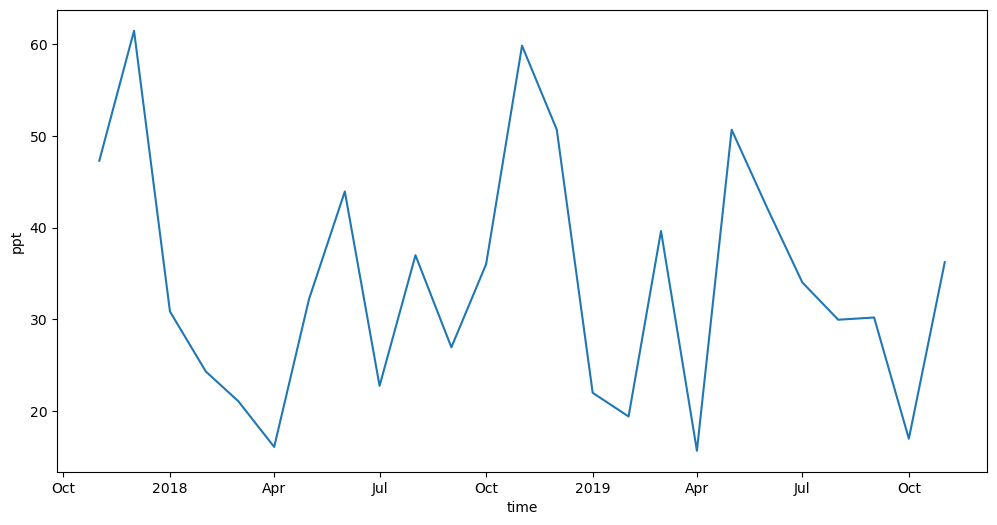

In [10]:
# Plot monthly accumulated precipitation over the region for 2 years
temperature = ds["ppt"].mean(dim=["lat", "lon"])
temperature.plot(figsize=(12, 6));

In [11]:
# Calculate the median of the dataset over time
soil_median = ds.soil.median(dim="time").compute()

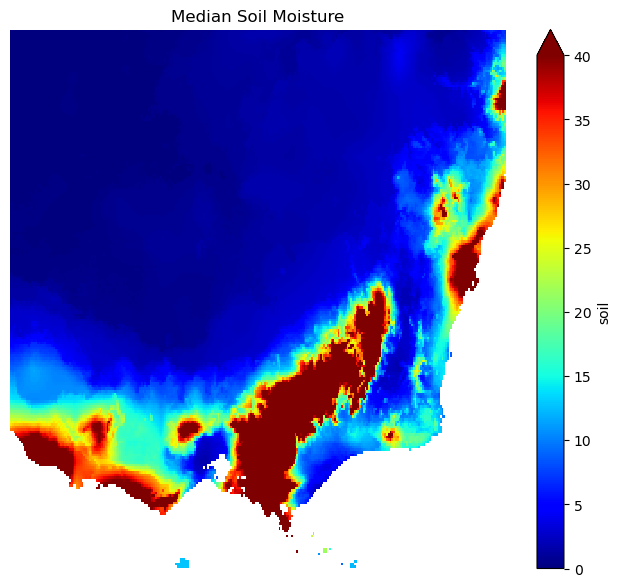

In [12]:
# Plot median soil moisture.
fig, ax = plt.subplots(figsize=(8,7))
soil_median.plot.imshow(vmin=0, vmax=40, cmap="jet")
plt.title("Median Soil Moisture")
plt.axis('off')
plt.show()

In [13]:
# Persist dataset in memory.
ds=ds.persist()

In [14]:
# Compute median along time dimension.
median = ds.median(dim="time", skipna=True).compute()

### Save the output data in a GeoTIFF file
The output product only contains 2 selected parameters that are used in the benchmark notebook. Participants may choose to include all of the parameters for their models to investigate how different parameters change their model results. 

In [15]:
#Define output file name.
filename = "TerraClimate_output.tiff"

In [16]:
# Calculate the dimensions of the file
height = median.dims["lat"]
width = median.dims["lon"]

In [17]:
# # Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# # Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(min_lon,min_lat,max_lon,max_lat,width,height)
median.rio.write_crs("epsg:4326", inplace=True)
median.rio.write_transform(transform=gt, inplace=True);


In [18]:
# Get a list of all available variables dynamically
variables = list(median.data_vars)

# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename, 'w', driver='GTiff', width=width, height=height,
                   crs='epsg:4326', transform=gt, count=len(variables),
                   compress='lzw', dtype='float64') as dst:
    
    # Loop through each variable and write it to a band
    for i, var in enumerate(variables):
        dst.write(median[var].values, i + 1)  # Write each variable as a separate band
        dst.set_band_description(i + 1, var)  # Store variable name in band metadata


In [19]:
# Show the location and size of the new output file
!ls *.tiff

TerraClimate_output.tiff


In [1]:
!pip install ace_tools


  Obtaining dependency information for ace_tools from https://files.pythonhosted.org/packages/27/c4/402d3ae2ecbfe72fbdcb2769f55580f1c54a3ca110c44e1efc034516a499/ace_tools-0.0-py3-none-any.whl.metadata
